In [1]:
import torch
import torchvision.transforms as transforms
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, Dataset
from torchvision.utils import make_grid
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from scipy import interpolate
import random
image_path = '/Users/patricknaylor/Desktop/Field_Detection/Images/Masked/'
model_path = '/Users/patricknaylor/Desktop/Field_Detection/data/Models/'
torch.__version__
device = torch.device('mps')



/Users/patricknaylor/miniconda3/envs/field_detect/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/patricknaylor/miniconda3/envs/field_detect/lib/python3.10/site-packages/torchvision/image.so, 0x0006): Symbol not found: __ZN2at4_ops19empty_memory_format4callEN3c108ArrayRefIxEENS2_8optionalINS2_10ScalarTypeEEENS5_INS2_6LayoutEEENS5_INS2_6DeviceEEENS5_IbEENS5_INS2_12MemoryFormatEEE
  Referenced from: <F0D48035-EF9E-3141-9F63-566920E60D7C> /Users/patricknaylor/miniconda3/envs/field_detect/lib/python3.10/site-packages/torchvision/image.so
  Expected in:     <B8EF5F9B-D0C8-3F96-967D-FE1E5F7F9E51> /Users/patricknaylor/miniconda3/envs/field_detect/lib/python3.10/site-packages/torch/lib/libtorch_cpu.dylib
  warn(f"Failed to load image Python extension: {e}")


Format Data data to match inputs of model

Mask files need to be transposed to match image shapes

In [2]:

images_paths = list(glob.glob(image_path + '*.jpg'))
scale_percent = 10

images = []
masks = []
for (img) in (images_paths):
    #Load and shrink images
    msk = f'{image_path}{img[59:-4]}.npy'
    image = cv2.cvtColor(cv2.imread(img), cv2.COLOR_BGR2RGB)
    width = int(image.shape[1] * scale_percent / 100)
    height = int(image.shape[0] * scale_percent / 100)
    images.append(cv2.resize(image, (width, height), interpolation = cv2.INTER_AREA))

    #Load and interpolate shrink masks
    mask = np.load(msk).T
    mask = mask[25: -25, 25: -25]
    x = np.linspace(0, 1, mask.shape[0])
    y = np.linspace(0, 1, mask.shape[1])
    f = interpolate.interp2d(y, x, mask, kind='linear')

    x2 = np.linspace(0, 1, 36)
    y2 = np.linspace(0, 1, 64)

    mask = f(y2, x2)
    mask = np.expand_dims(mask, axis=2)
    
    masks.append(mask)

print(f'Image size: {image.shape}\nMask size: {mask.shape}')


Image size: (720, 1280, 3)
Mask size: (36, 64, 1)


In [3]:
images_arr = np.stack(images)
masks_arr = np.stack(masks)
images_arr = images_arr.astype(np.uint8)
masks_arr[masks_arr > 0] = 1
masks_arr[masks_arr <= 0] = 0
masks_arr = masks_arr.astype(np.uint8)

Randomly reflect images along the x and y axis.

Most images are oriented with masked are near the top of the image which creates bias.

In [4]:
for i in range(np.shape(images_arr)[0]):
    rand1 = random.randint(1, 2)
    rand2 = random.randint(1, 2)
    temp_arr_im = images_arr[i, :, :, :]
    temp_arr_msk = masks_arr[i, :, :, :]
    if rand1 == 2:
        temp_arr_im = np.flip(temp_arr_im, 0)
        temp_arr_msk = np.flip(temp_arr_msk, 0)
    if rand2 == 2:
        temp_arr_im = np.flip(temp_arr_im, 1)
        temp_arr_msk = np.flip(temp_arr_msk, 1)
    images_arr[i, :, :, :] = temp_arr_im
    masks_arr[i, :, :, :] = temp_arr_msk


Create image dataset and transform images into PyTorch format

In [5]:
class imageDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        image = self.X[index]
        mask = self.y[index]
        y = torch.tensor(mask)
        X = self.transform(image)
        return [X, y]

    transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()])

Generate dataloaders for training data and two validation sets

Using 1/6 of data for validation

In [6]:
batch_size = 200
transformed_dataset = imageDataset(X=images_arr, y=masks_arr)
val_size = np.shape(masks_arr)[0]//6
train_size = np.shape(masks_arr)[0] - val_size
train_set, val_set = torch.utils.data.random_split(transformed_dataset, [train_size, val_size])
train_dl = DataLoader(train_set, batch_size, shuffle=True)
val1_dl = DataLoader(val_set, 1, shuffle=True)
val2_dl = DataLoader(val_set, val_size, shuffle=True)
print(f'Number of training images: {train_size} \nNumber of validation images: {val_size}')



Number of training images: 3000 
Number of validation images: 600


### Model class

Two convolutional layers with one pooling layer.

Three fully connected linear layers

relu used for activation 


In [7]:
class Model(nn.Module):
    def __init__(self):
        super(Model, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5, padding='same')
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 5, padding='same')
        self.fc1 = nn.Linear(int(12*72*128*.25), int(4*72*128*.25))
        self.fc2 = nn.Linear(int(4*72*128*.25), int(2*72*128*.25))       
        self.fc3 = nn.Linear(int(2*72*128*.25), int(1*72*128*.25))
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


Using Binary Cross Entropy with Logits Loss for loss as it supports multi-label classification

Using Stochastic gradient descent

In [8]:
model = Model().to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum = .9)

In [9]:
num_epochs = 500
n_total_steps = len(train_dl)
for epoch in range(num_epochs):
    running_loss = 0.0
    sum = 0
    for i, (input, target) in enumerate(train_dl):
        input = input.to(device)
        target = torch.flatten(target, 1).to(device)


        outputs = model(input)
        loss = criterion(outputs, target.float())

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        sum += 1
    if epoch%10 == 0:
        print (f'Epoch [{epoch}/{num_epochs}], Loss: {loss.item():.4f}')



Epoch [0/500], Loss: 0.6931
Epoch [10/500], Loss: 0.5887
Epoch [20/500], Loss: 0.5692
Epoch [30/500], Loss: 0.5903
Epoch [40/500], Loss: 0.2825
Epoch [50/500], Loss: 0.2457
Epoch [60/500], Loss: 0.2241
Epoch [70/500], Loss: 0.1878
Epoch [80/500], Loss: 0.1702
Epoch [90/500], Loss: 0.1576
Epoch [100/500], Loss: 0.1378
Epoch [110/500], Loss: 0.1451
Epoch [120/500], Loss: 0.1272
Epoch [130/500], Loss: 0.1310
Epoch [140/500], Loss: 0.1227
Epoch [150/500], Loss: 0.1149
Epoch [160/500], Loss: 0.1166
Epoch [170/500], Loss: 0.1108
Epoch [180/500], Loss: 0.1184
Epoch [190/500], Loss: 0.1079
Epoch [200/500], Loss: 0.1073
Epoch [210/500], Loss: 0.1004
Epoch [220/500], Loss: 0.0945
Epoch [230/500], Loss: 0.0972
Epoch [240/500], Loss: 0.0937
Epoch [250/500], Loss: 0.0990
Epoch [260/500], Loss: 0.0860
Epoch [270/500], Loss: 0.0893
Epoch [280/500], Loss: 0.0829
Epoch [290/500], Loss: 0.0900
Epoch [300/500], Loss: 0.0830
Epoch [310/500], Loss: 0.0939
Epoch [320/500], Loss: 0.0777
Epoch [330/500], Loss

In [10]:
with torch.no_grad():
    for (images, labels) in val2_dl:
        images = images.to(device)
        labels = labels.to(device)
        output = model(images)
        loss = criterion(output, torch.flatten(labels,1, 3).float())
        print(f'Loss over {val_size} samples: {loss.item()}')
        break

Loss over 600 samples: 0.09990158677101135


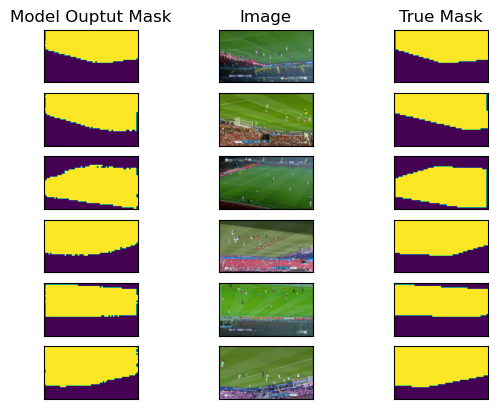

In [11]:
with torch.no_grad():
    for idx, (images, labels) in enumerate(val1_dl):
        images = images.to(device)
        labels = labels.to(device)
        image = images[0,:,:,:]
        mask = labels[0,:,:,:]
        output = model(images)
        output = output.reshape(36, 64)
        plt.subplot(6,3,(idx*3)+1)
        model_output = torch.Tensor.cpu(F.sigmoid(output))
        model_output[model_output>.5] = 1
        model_output[model_output<=.5] = 0
        plt.yticks([])
        plt.xticks([])
        plt.imshow(model_output, vmin=0, vmax=1)
        if(idx == 0):
            plt.title('Model Ouptut Mask')

        plt.subplot(6,3,(3*idx)+2)
        plt.yticks([])
        plt.xticks([])
        plt.imshow(torch.Tensor.cpu(image).permute(1, 2, 0))
        if(idx == 0):
            plt.title('Image')
            
        plt.subplot(6,3,(3*idx)+3)
        plt.yticks([])
        plt.xticks([])
        plt.imshow(torch.Tensor.cpu(mask))
        if(idx == 0):
            plt.title('True Mask')
        if idx == 5:
            break

In [12]:
torch.save(model.state_dict(), model_path + 'model_1.pth')